<h1 style="text-align:center;font-size:30px;" > Question Answer Prediction </h1>

<h1> 1. Business Problem </h1>

<h1>2. Machine Learning Probelm </h1>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file data.tsv <br>
- data.tsv contains 5 columns  <br>
- Size of data.tsv - 2 GB <br>
- Number of rows in Tdata.tsv is 52,41,880
</p>

<h3> 2.1.2 Example Data point </h3>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Deep Leaning Problem </h3>

<p> It is a binary classification problem, for a given data we need to predict whether the given aswer is correct  or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Metric(s): 
* MRR : https://en.wikipedia.org/wiki/Mean_reciprocal_rank
* F1_Score 

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by selecting unique questions from total data and split first 70% of Questions as Train, next 10 % as Cv and remaining 20% as Test. </p>

<h1>3. Data Overview </h1>

In [2]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm_notebook
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from datetime import datetime
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')

<h2> 3.1 Reading data </h2>

In [2]:
#loading Data from Tab seperated file
data = pd.read_csv('data.tsv',sep ='\t',header=None)
data.columns = ['Q_id','Question','Answer','Target','Respose_number']

In [3]:
data.head()

,Q_id,Question,Answer,Target,Respose_number
0,0,. what is a corporation?,A company is incorporated in a specific nation...,0,0
1,0,. what is a corporation?,"Today, there is a growing community of more th...",0,1
2,0,. what is a corporation?,"Corporation definition, an association of indi...",0,2
3,0,. what is a corporation?,Examples of corporation in a Sentence. 1 He w...,0,3
4,0,. what is a corporation?,1: a government-owned corporation (as a utilit...,0,4


In [4]:
print("Number of samples data points : {}\nNumber of Coumns : {}".format(data.shape[0],data.shape[1]))

Number of samples data points : 5241880
Number of Coumns : 5


In [5]:
print('Colum names : ', data.columns)

Colum names :  Index(['Q_id', 'Question', 'Answer', 'Target', 'Respose_number'], dtype='object')


In [6]:
print("Does the dat have any missing values : ",data.isna().any().any())

Does the dat have any missinf values :  False


In [7]:
unique_question = data.Question.unique()
print("Total number of unique question before preprocessing data : ",len(unique_question))

Total number of unique question before preprocessing data :  524188


In [8]:
# Finding number of questions sharing same Q_id
df = data.groupby('Q_id').agg({'Target':['count']})
cols = ['Count']
df.columns = cols
print("Number of Questions with duplicat question id : ",df[df.Count>10].shape[0])

Number of Questions with duplicat question id :  31455


In [9]:
#Giving Unique Qid for each Questions
Q_id  =[]
for i in range(524188):
    ind =list(np.array([1,1,1,1,1,1,1,1,1,1])*i)
    Q_id.extend(ind)
data['Q_id'] = np.array(Q_id)

In [10]:
df = data.groupby('Q_id').agg({'Target':['count']})
cols = ['Count']
df.columns = cols
print("Number of Questions with duplicat question id : ",df[df.Count>10].shape[0])

Number of Questions with duplicat question id :  0


<h2> 3.2 Sampling Data to reduce process time </h2>

In [11]:
#selecting first 70% of Questions to tran and test
unique = data.Question.unique()
sample_data_question_to_remove = unique[int(len(unique)*0.70):]
data.drop(data[data.Question.isin((sample_data_question_to_remove))].index,inplace = True)
data.shape

(3669310, 5)

<h1> 4  Text pre-processing </h1>

<h2> 4.1  Removing Special characters </h2>

Sample of 10 questins how my question looks after removel of non alpha numeric charaters

In [16]:
unique = data.Question.unique()
for i in range(55100,55110):
    print('Before pre_processing:', unique[i])
    sub = re.sub('[^A-Za-z0-9]+', ' ', unique[i])
    print("After pre_processing:"," ".join(e.lower() for e in sub.split(' ')))
    print("*"*50)

Before pre_processing: what is two intersecting lines that form a right angle
After pre_processing: what is two intersecting lines that form a right angle
**************************************************
Before pre_processing: which vessels carries blood from the lungs to the heart
After pre_processing: which vessels carries blood from the lungs to the heart
**************************************************
Before pre_processing: how many miles of blood vessels are there in the human body?
After pre_processing: how many miles of blood vessels are there in the human body 
**************************************************
Before pre_processing: when did the european rabbit come to australia
After pre_processing: when did the european rabbit come to australia
**************************************************
Before pre_processing: what political district is hampton roads
After pre_processing: what political district is hampton roads
**************************************************


In [17]:
preprocessed_Questions = []
for sentance in (data['Question'].values):
    sent = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sent = ' '.join(e.lower() for e in sent.split())
    preprocessed_Questions.append(sent)

In [18]:
preprocessed_Answers = []
for sentance in (data['Answer'].values):
    sent = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sent = ' '.join(e.lower() for e in sent.split())
    preprocessed_Answers.append(sent)

In [19]:
data['Question'] = preprocessed_Questions
data['Answer'] = preprocessed_Answersx

<h2> 4.2  Find Duplicates and remove duplicates </h2>

In [21]:
dup_data= data.duplicated(subset = ['Question','Answer','Target'])
values,count = np.unique(dup_data,return_counts=True)
print('Number of duplicates : ',count[1])

Number of duplicates :  12235


In [22]:
#Sorting data according to Target in ascending order and remove dupe
sorted_data=data.sort_values('Target', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset=['Question','Answer','Target'], keep='first', inplace=False)
final.shape

(3657075, 5)

In [23]:
df = final.groupby('Question').agg({'Target':['sum','count']})
cols = ['sum_y','count_y']
df.columns = cols
df.head()

,sum_y,count_y
Question,,
0 50 clonazepam how long to take effect,1,10
01604 area code telephone,1,10
0843 phone numbers cost,1,10
1 1 explain what it means to have a duty of care in own work role,1,10
1 1 identify how infections are spread,1,9


In [24]:
print("Any Question have 0 correct answer : ", np.any(df['sum_y']==0))
print("Any Question have more than 1 correct answer : ", np.any(df['sum_y']>1))
print("Does any of my question have less than or more than 10 response : ",np.any(df['count_y'] != 10))

Any Question have 0 correct answer :  False
Any Question have more than 1 correct answer :  True
Does any of my question have less than or more than 10 response :  True


In [25]:
#removing questions which has less than or more than 10 response
questins_which_dont_have_exactly_10_response = np.unique(df.index[df['count_y'] != 10])
final.drop(final[final.Question.isin(questins_which_dont_have_exactly_10_response)].index,inplace = True)

In [26]:
data_without_duplicate = final.sort_values(by = ['Q_id','Question','Respose_number'], axis=0, ascending=True, inplace=False, kind='quicksort')
data_without_duplicate.head()

,Q_id,Question,Answer,Target,Respose_number
0,0,what is a corporation,a company is incorporated in a specific nation...,0,0
1,0,what is a corporation,today there is a growing community of more tha...,0,1
2,0,what is a corporation,corporation definition an association of indiv...,0,2
3,0,what is a corporation,examples of corporation in a sentence 1 he wor...,0,3
4,0,what is a corporation,1 a government owned corporation as a utility ...,0,4


In [29]:
df = data_without_duplicate.groupby(['Question']).agg({'Target':['sum','count']})
cols = ['sum_y','count_y']
df.columns = cols

print("Any Question have 0 correct answer : ", np.any(df['sum_y']==0))
print("Any Question have more than 1 correct answer : ", np.any(df['sum_y']>1))
print("Does any of my question have less than or more than 10 response : ",np.any(df['count_y'] != 10))

Any Question have 0 correct answer :  False
Any Question have more than 1 correct answer :  False
Does any of my question have less than or more than 10 response :  False


In [30]:
data_without_duplicate.to_csv('data_without_duplicate.csv',index = False)
print("Number of question after pre processing : ",len(data_without_duplicate.Question.unique()))

Number of question after pre processing :  354627


<h1> 5. Check distribution of length </h1>

In [31]:
def lent(sen):
    return len(sen.split(' '))
question_lenth = list(map(lent,preprocessed_Questions))
Answer_lenth = list(map(lent,preprocessed_Answers))
print('smallest Question Length {},Largest Question Length {}'.format(min(question_lenth),max(question_lenth)))
print('smallest Answer Length {},Largest Answer Length {}'.format(min(Answer_lenth),max(Answer_lenth)))

smallest Question Length 1,Largest Question Length 40
smallest Answer Length 1,Largest Answer Length 269


In [32]:
print('Sample Smallest Question :',data_without_duplicate['Question'].iloc[question_lenth.index(1)])
print('Sample Smallest Answer :',data_without_duplicate['Answer'].iloc[Answer_lenth.index(1)])

Sample Smallest Question : contribute definition
Sample Smallest Answer : get directions store hours and services for the o reilly auto parts at 581 commerce drive in smelterville id order your brakes batteries and parts online and pick up in store today


In [33]:
print('Sample Largest Question :',data_without_duplicate['Question'].iloc[question_lenth.index(27)])
print('Sample Largest Answer :',data_without_duplicate['Answer'].iloc[Answer_lenth.index(244)])

Sample Largest Question : which states donated the land for dc
Sample Largest Answer : change management change management sometimes abbreviated as cm is a collective term for all approaches to preparing and supporting individuals teams and organizations in making organizational change


Text(0.5, 1.0, 'Length of question Vs count')

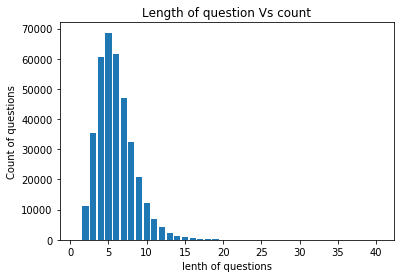

In [34]:
unique,count = np.unique(np.array(question_lenth), return_counts=True)
plt.bar(unique,count/10) # as every question is repeated 10 times we divide by 10
plt.xlabel('lenth of questions')
plt.ylabel('Count of questions')
plt.title('Length of question Vs count')

Text(0.5, 1.0, 'Length of Answer Vs count')

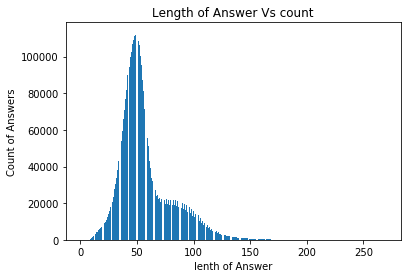

In [35]:
unique,count = np.unique(np.array(Answer_lenth), return_counts=True)
plt.bar(unique,count) 
plt.xlabel('lenth of Answer')
plt.ylabel('Count of Answers')
plt.title('Length of Answer Vs count')

<h1> 6. Splitting data into Test, train, Cv </h1>

In [36]:
del data
data = data_without_duplicate.copy()
#data = pd.read_csv('data_without_duplicate.csv')

In [39]:
#selecting first 70% of question for train ,next 10% for Cv and remaining for test data
unique = data.Question.unique()
train_questions = unique[:int(len(unique)*0.70)]
cv_questions = unique[int(len(unique)*0.70):int(len(unique)*0.80)]
test_questions = unique[int(len(unique)*0.80):]

In [43]:
train_data = data[data.Question.isin (train_questions)]
cv_data = data[data.Question.isin (cv_questions)]
test_data = data[data.Question.isin (test_questions)]
print("Data points of train : {} \nData points of cv : {}\nData points of test : {}".format(train_data.shape[0],cv_data.shape[0] ,test_data.shape[0]))

Data points of train : 2482380 
Data points of cv : 354630
Data points of test : 709260


<h1> 7. Removing non keywords from Question and answer </h1>

## 7.1 Finding top 10000 keywords using Tfidf

In [44]:
train_data['Question'][train_data['Question'].isnull()]

Series([], Name: Question, dtype: object)

In [45]:
Tfidf_vect = TfidfVectorizer(max_features = 10000)
Tfidf_vect.fit(train_data['Question'])
Question_keywords = Tfidf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",Question_keywords[0:10])
print('Number of key words we are considering in Question : ',len(Question_keywords))
np.save('Questin_Answer_10000_keywords/Question_keywords',np.array(Question_keywords),allow_pickle=True)

some sample features(unique words in the corpus) ['10', '100', '11', '12', '13', '14th', '15', '16', '18', '1964']
Number of key words we are considering in Question :  10000


In [46]:
Tfidf_vect = TfidfVectorizer(max_features = 10000)
Tfidf_vect.fit(train_data['Answer'])
Answer_keywords = Tfidf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",Answer_keywords[0:10])
print('Number of all keey words we are considering in Answers : ',len(Answer_keywords))
np.save('Questin_Answer_10000_keywords/Answer_keywords',np.array(Answer_keywords),allow_pickle=True)

some sample features(unique words in the corpus) ['00', '000', '001', '00pm', '01', '02', '03', '04', '05', '06']
Number of all keey words we are considering in Answers :  10000


## 7.2 Processing Question by removing Non Keywords

In [47]:
train_que_which_has_ly_keywords = []
for sentance in train_data['Question']:
    sent = ' '.join(e for e in sentance.split() if e in Question_keywords)
    train_que_which_has_ly_keywords.append(sent)


cv_que_which_has_ly_keywords = []
for sentance in cv_data['Question']:
    sent = ' '.join(e for e in sentance.split() if e in Question_keywords)
    cv_que_which_has_ly_keywords.append(sent)


test_que_which_has_ly_keywords = []
for sentance in test_data['Question']:
    sent = ' '.join(e for e in sentance.split() if e in Question_keywords)
    test_que_which_has_ly_keywords.append(sent)


### 7.2.1 Distribution of length of Question after removal of Keywords

Number of Train questions which has no top 10000 kew words :  2010
Max lenth of question after keyword removal :  36
Number of question with max length after keyword removal :  10


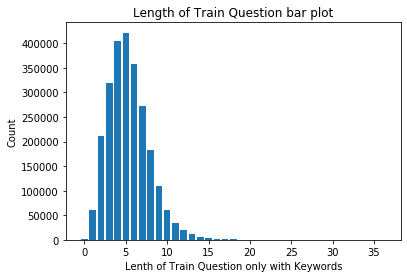

In [48]:
length_of_train_que_after_removel_of_top_words = [len(i.split(" ")) for i in train_que_which_has_ly_keywords if len(i)>0]

unique,count = np.unique(np.array(length_of_train_que_after_removel_of_top_words), return_counts=True)
length_question_dict = dict((zip(unique,count)))
length_question_dict[0] = len(train_que_which_has_ly_keywords)- sum(count)
length_question_dict = OrderedDict(sorted(length_question_dict.items(), key=lambda t: t[0]))
plt.bar(list(length_question_dict.keys()),list(length_question_dict.values()))
plt.xlabel('Lenth of Train Question only with Keywords')
plt.ylabel('Count')
plt.title('Length of Train Question bar plot')
print("Number of Train questions which has no top 10000 kew words : ",length_question_dict[0])

print("Max lenth of question after keyword removal : ", max(length_question_dict.keys()))
print("Number of question with max length after keyword removal : ", length_question_dict.get(max(length_question_dict.keys())))

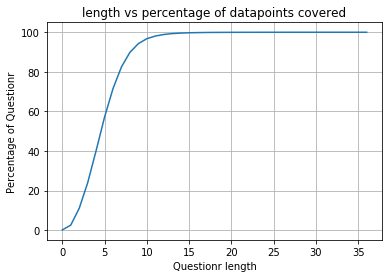

In [49]:
cumsum = np.cumsum(list(length_question_dict.values()))
per = cumsum*100/cumsum[-1]
plt.plot(list(length_question_dict.keys()),per)
plt.xlabel("Questionr length")
plt.ylabel("Percentage of Questionr")
plt.title("length vs percentage of datapoints covered")
plt.grid()

If I take Question with length of 24, I cover 99.98791482367727 % of DataPoints
Number of data points having Ans length greater than  24 is : 300


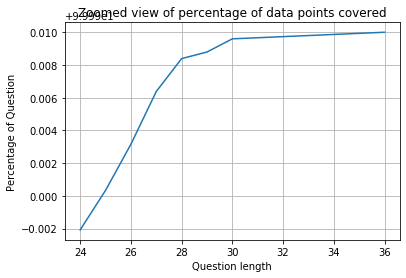

In [50]:
neg_ind = -8
cumsum = np.cumsum(list(length_question_dict.values()))[neg_ind:]
per = cumsum*100/cumsum[-1]
print("If I take Question with length of {}, I cover {} % of DataPoints".format((list(length_question_dict.keys())[neg_ind]),list(per)[0]))
print("Number of data points having Ans length greater than  {} is : {}".format((list(length_question_dict.keys())[neg_ind]),(cumsum[-1]-cumsum[neg_ind])))
plt.plot(list(length_question_dict.keys())[neg_ind:],per)
plt.xlabel("Question length")
plt.ylabel("Percentage of Question")
plt.title("Zoomed view of percentage of data points covered")
plt.grid()

Number of CV questions which has no top 10000 kew words :  400
Max lenth of question after keyword removal :  31
Number of question with max length after keyword removal :  10


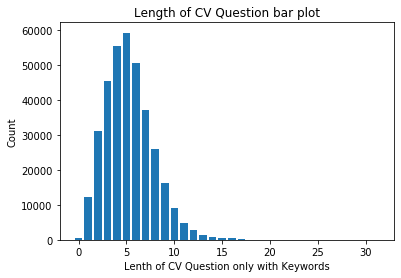

In [51]:
length_of_cv_que_after_removel_of_top_words = [len(i.split(" ")) for i in cv_que_which_has_ly_keywords if len(i)>0]
unique,count = np.unique(np.array(length_of_cv_que_after_removel_of_top_words), return_counts=True)
length_question_dict = dict((zip(unique,count)))
length_question_dict[0] = len(cv_que_which_has_ly_keywords) - sum(count)
length_question_dict = OrderedDict(sorted(length_question_dict.items(), key=lambda t: t[0]))
plt.bar(list(length_question_dict.keys()),list(length_question_dict.values()))
plt.xlabel('Lenth of CV Question only with Keywords')
plt.ylabel('Count')
plt.title('Length of CV Question bar plot')
print("Number of CV questions which has no top 10000 kew words : ",length_question_dict[0])
print("Max lenth of question after keyword removal : ", max(length_question_dict.keys()))
print("Number of question with max length after keyword removal : ", length_question_dict.get(max(length_question_dict.keys())))

Number of Test questions which has no top 10000 kew words :  810
Max lenth of question after keyword removal :  33
Number of question with max length after keyword removal :  10


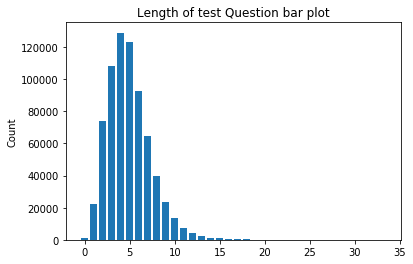

In [52]:
length_of_test_que_after_removel_of_top_words = [len(i.split(" ")) for i in test_que_which_has_ly_keywords if len(i)>0]
unique,count = np.unique(np.array(length_of_test_que_after_removel_of_top_words), return_counts=True)
length_question_dict = dict((zip(unique,count)))
length_question_dict[0] = len(test_que_which_has_ly_keywords) - sum(count)
length_question_dict = OrderedDict(sorted(length_question_dict.items(), key=lambda t: t[0]))
plt.bar(list(length_question_dict.keys()),list(length_question_dict.values()))
plt.ylabel('Count')
plt.title('Length of test Question bar plot')
print("Number of Test questions which has no top 10000 kew words : ",length_question_dict[0])
print("Max lenth of question after keyword removal : ", max(length_question_dict.keys()))
print("Number of question with max length after keyword removal : ", length_question_dict.get(max(length_question_dict.keys())))

In [53]:
train_data.head()

,Q_id,Question,Answer,Target,Respose_number
0,0,what is a corporation,a company is incorporated in a specific nation...,0,0
1,0,what is a corporation,today there is a growing community of more tha...,0,1
2,0,what is a corporation,corporation definition an association of indiv...,0,2
3,0,what is a corporation,examples of corporation in a sentence 1 he wor...,0,3
4,0,what is a corporation,1 a government owned corporation as a utility ...,0,4


In [54]:
train_data['Question'] = train_que_which_has_ly_keywords
test_data['Question'] = test_que_which_has_ly_keywords
cv_data['Question'] = cv_que_which_has_ly_keywords

## 7.3 Processing Answer by Removing Non keywords

In [56]:
train_ans_which_has_ly_keywords = []
for sentance in train_data['Answer']:
    sent = ' '.join(e for e in sentance.split() if e in Answer_keywords)
    train_ans_which_has_ly_keywords.append(sent)

    
cv_ans_which_has_ly_keywords = []
for sentance in cv_data['Answer']:
    sent = ' '.join(e for e in sentance.split() if e in Answer_keywords)
    cv_ans_which_has_ly_keywords.append(sent)


test_ans_which_has_ly_keywords = []
for sentance in test_data['Answer']:
    sent = ' '.join(e for e in sentance.split() if e in Answer_keywords)
    test_ans_which_has_ly_keywords.append(sent)


### 7.3.1 Distribution of length of Answer after removal of Keywords

Number of Train Answer which has no top 10000 kew words :  86
Max lenth of answer after keyword removal :  227
Number of answers with max length after keyword removal :  1


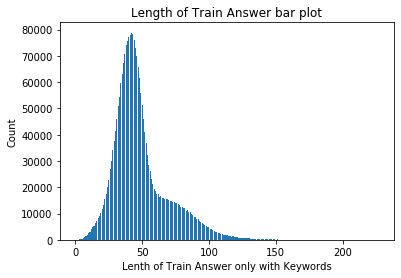

In [59]:
length_of_train_ans_after_removel_of_top_words = [len(i.split(" ")) for i in train_ans_which_has_ly_keywords if len(i)>0]

unique,count = np.unique(np.array(length_of_train_ans_after_removel_of_top_words), return_counts=True)
length_answer_dict = dict((zip(unique,count)))
length_answer_dict[0] = len(train_ans_which_has_ly_keywords) - sum(count)
length_answer_dict = OrderedDict(sorted(length_answer_dict.items(), key=lambda t: t[0]))
plt.bar(list(length_answer_dict.keys()),list(length_answer_dict.values()))
plt.xlabel('Lenth of Train Answer only with Keywords')
plt.ylabel('Count')
plt.title('Length of Train Answer bar plot')
print("Number of Train Answer which has no top 10000 kew words : ",length_answer_dict[0])

print("Max lenth of answer after keyword removal : ", max(length_answer_dict.keys()))
print("Number of answers with max length after keyword removal : ", length_answer_dict.get(max(length_answer_dict.keys())))

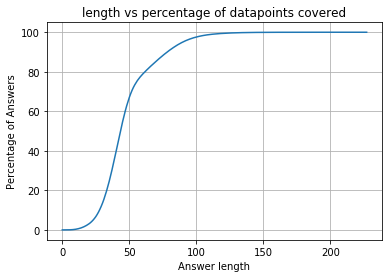

In [60]:
cumsum = np.cumsum(list(length_answer_dict.values()))
per = cumsum*100/cumsum[-1]
plt.plot(list(length_answer_dict.keys()),per)
plt.xlabel("Answer length")
plt.ylabel("Percentage of Answers")
plt.title("length vs percentage of datapoints covered")
plt.grid()

If I take Answer with length of 163, I cover 99.98263763001636 % of DataPoints
Number of data points having Ans length greater than  163 is : 431


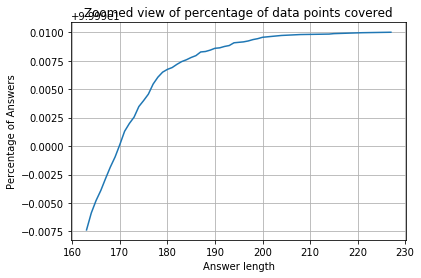

In [65]:
neg_ind = -45
cumsum = np.cumsum(list(length_answer_dict.values()))[neg_ind:]
per = cumsum*100/cumsum[-1]
print("If I take Answer with length of {}, I cover {} % of DataPoints".format((list(length_answer_dict.keys())[neg_ind]),list(per)[0]))
print("Number of data points having Ans length greater than  {} is : {}".format((list(length_answer_dict.keys())[neg_ind]),(cumsum[-1]-cumsum[neg_ind])))
plt.plot(list(length_answer_dict.keys())[neg_ind:],per)
plt.xlabel("Answer length")
plt.ylabel("Percentage of Answers")
plt.title("Zoomed view of percentage of data points covered")
plt.grid()

Number of CV Answer which has no top 10000 kew words :  0
Max lenth of answer after keyword removal :  218
Number of answers with max length after keyword removal :  1


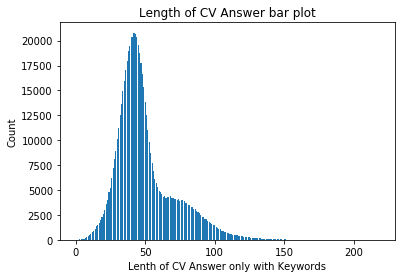

In [71]:
length_of_cv_ans_after_removel_of_top_words = [len(i.split(" ")) for i in cv_ans_which_has_ly_keywords if len(i)>0]

unique,count = np.unique(np.array(length_of_cv_ans_after_removel_of_top_words), return_counts=True)
length_answer_dict = dict((zip(unique,count)))
length_answer_dict[0] = len(cv_ans_which_has_ly_keywords) - sum(count)
length_answer_dict = OrderedDict(sorted(length_answer_dict.items(), key=lambda t: t[0]))
plt.bar(list(length_answer_dict.keys()),list(length_answer_dict.values()))
plt.xlabel('Lenth of CV Answer only with Keywords')
plt.ylabel('Count')
plt.title('Length of CV Answer bar plot')
print("Number of CV Answer which has no top 10000 kew words : ",length_answer_dict[0])

print("Max lenth of answer after keyword removal : ", max(length_answer_dict.keys()))
print("Number of answers with max length after keyword removal : ", length_answer_dict.get(max(length_answer_dict.keys())))

Number of Test Answer which has no top 10000 kew words :  0
Max lenth of answer after keyword removal :  253
Number of answers with max length after keyword removal :  1


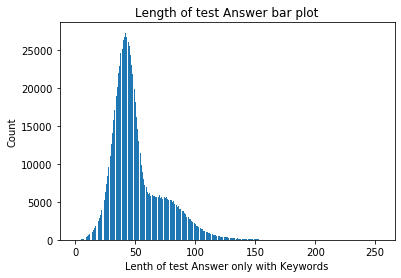

In [72]:
length_of_test_ans_after_removel_of_top_words = [len(i.split(" ")) for i in test_ans_which_has_ly_keywords if len(i)>0]
unique,count = np.unique(np.array(length_of_test_ans_after_removel_of_top_words), return_counts=True)
length_answer_dict = dict((zip(unique,count)))
length_answer_dict[0] = len(test_ans_which_has_ly_keywords) - sum(count)
length_answer_dict = OrderedDict(sorted(length_answer_dict.items(), key=lambda t: t[0]))
plt.bar(list(length_answer_dict.keys()),list(length_answer_dict.values()))
plt.xlabel('Lenth of test Answer only with Keywords')
plt.ylabel('Count')
plt.title('Length of test Answer bar plot')
print("Number of Test Answer which has no top 10000 kew words : ",length_answer_dict[0])

print("Max lenth of answer after keyword removal : ", max(length_answer_dict.keys()))
print("Number of answers with max length after keyword removal : ", length_answer_dict.get(max(length_answer_dict.keys())))

In [ ]:
train_data['Answer'] = train_ans_which_has_ly_keywords
test_data['Answer'] = test_ans_which_has_ly_keywords
cv_data['Answer'] = cv_ans_which_has_ly_keywords
train_data.to_csv("Final_Test_Train_CV/train_data.csv",index = False)
cv_data.to_csv('Final_Test_Train_CV/cv_data.csv',index = False)
test_data.to_csv('Final_Test_Train_CV/test_data.csv',index = False)

<h2> 8. Droping Data points </h2>

### 8.1 Droping all Que and answer rows with does not have any of top 10000 keywords

In [73]:
print("Train data shape Before dropping all Que and answer rows with does not have any of top 10000 keywords : ",train_data.shape)
train_data.dropna(axis=0,inplace = True)
train_data.drop(train_data[train_data.Question.isin([""])].index,inplace = True)
train_data.drop(train_data[train_data.Answer.isin([""])].index,inplace = True)
print("Train data shape after dropping all Que and answer rows with does not have any of top 10000 keywords : ",train_data.shape)

Train data shape Before dropping all Que and answer rows with does not have any of top 10000 keywords :  (2482380, 5)
Train data shape after dropping all Que and answer rows with does not have any of top 10000 keywords :  (2480286, 5)


### 8.2 Droping question with has no correct answer and more than 10 response

In [74]:
df = train_data.groupby('Question').agg({'Target':['sum','count']})
cols = ['Num_of_correct_ans','Tot_num_ans']
df.columns = cols
df.head()

,Num_of_correct_ans,Tot_num_ans
Question,,
10 steps is how many miles,1,10
11 11 meaning,1,10
11 11 what does it mean,1,10
11 is what day of 2016,1,10
12 ounces converted to cups,1,10


In [75]:
print("Any Question have 0 correct answer : ", np.any(df['Num_of_correct_ans']==0))
print("Any Question have more than 1 correct answer : ", np.any(df['Num_of_correct_ans']>1))
print("Does any of my Question dont have exactly 10 answers : ",np.any(df['Tot_num_ans'] !=10))

Any Question have 0 correct answer :  False
Any Question have more than 1 correct answer :  True
Does any of my Question dont have exactly 10 answers :  True


In [76]:
Questins_which_dont_have_exactly_10_response = np.unique(df.index[df['Tot_num_ans'] != 10])
print("Total number of questions which does not have exact 10 Response : ",len(Questins_which_dont_have_exactly_10_response))
print("\nSample Questions which dont have exact 10 Response :\n",Questins_which_dont_have_exactly_10_response[:10])

Total number of questions which does not have exact 10 Response :  6378

Sample Questions which dont have exact 10 Response :
 ['academic definition' 'acceptance rate' 'accounting definition'
 'activity definition' 'actor' 'actress' 'actress who played'
 'acura price' 'adam' 'address']


In [ ]:
Questions_with_no_correct_answer = list(df[df['Num_of_correct_ans']==0].index)
print("Total number of questions which has 0 correct answer : ",len(Questions_with_no_correct_answer))

### 8.3 Removing the questions with has 0 correct answer and dont have exactly 10 response

In [78]:
questins_which_dont_have_exactly_10_response = np.unique(df.index[df['Tot_num_ans'] != 10])
questins_which_dont_no_correct_answer = np.unique(df.index[df['Num_of_correct_ans'] == 0])
train_data.drop(train_data[train_data.Question.isin((questins_which_dont_have_exactly_10_response))].index,inplace = True)
train_data.drop(train_data[train_data.Question.isin((questins_which_dont_no_correct_answer))].index,inplace = True)
print("Train data shape after dropping all Ques with does not have atleasr one correct answer and more than 10 response : ",train_data.shape[0])

Train data shape after dropping all Ques with does not have atleasr one correct answer and more than 10 response :  2009790


<h2> 9. Setting numerical value to each word in questions </h2>

In [79]:
#Sample how we vectorize the data
sentance_as_list = 'immediate impact success manhattan project'
list(map(lambda x: Question_keywords.index(x)+1,sentance_as_list.split(" ")))

[4484, 4490, 8679, 5451, 7099]

### 9.1 Setting numeric value to Train data 

In [81]:
start = datetime.now()
print("Started encoding traind datas Questions")
train_ecoded_ques = []
for train_ques in tqdm_notebook(train_data['Question']):
    train_ecoded_ques.append(list(map(lambda x: Question_keywords.index(x)+1,train_ques.split(" "))))

print("Started encoding traind datas Answers")
train_ecoded_ans = []
for train_ans in tqdm_notebook(train_data['Answer']):
    train_ecoded_ans.append(list(map(lambda x: Answer_keywords.index(x)+1,train_ans.split(" "))))
    
print("Time Taken to encode train datas Question and answer : ",datetime.now() - start)

Started encoding traind datas Questions


Started encoding traind datas Answers


Time Taken to encode train datas Question and answer :  3:43:54.023313


In [82]:
train_data["Question_vector"] = train_ecoded_ques
train_data["Answer_vector"] = train_ecoded_ans

### 9.2 Setting numeric value to Test and Cv by creating function

In [ ]:
def encoder(data_column,keyword):
    ecoded_list = []
    for string in tqdm(data_column):
        ecoded_list.append(list(map(lambda x: keyword.index(x)+1,string.split(" "))))
    return ecoded_list

In [ ]:
def drop_rows_and_encode(data,data_name,Question_keywords,Answer_keywords):
    
    print("Processing of "+data_name)
    
    print("Number of data points in "+data_name+ " before dropping all Que and answer rows with does not have any of top 10000 keywords : ", data.shape[0])
    
    #Droping all Que and answer rows with does not have any of top 10000 keywords 
    data.dropna(axis=0,inplace = True)
    print("Number of data points in "+data_name+ " after dropping all Que and answer rows with does not have any of top 10000 keywords : ",data.shape[0])
    
    #Find question with has no correct answer and more than 10 response
    df = data.groupby('Question').agg({'Target':['sum','count']})
    cols = ['Num_of_correct_ans','Tot_num_ans']
    df.columns = cols
    
    
    Questins_which_dont_have_exactly_10_response = np.unique(df.index[df['Tot_num_ans'] != 10])
    print("Total number of "+data_name+" questions which does not have exact 10 Response : ",len(Questins_which_dont_have_exactly_10_response))
    print("\nSample Questions which dont have exact 10 Response :\n",Questins_which_dont_have_exactly_10_response[:10])
    
    
    Questions_with_no_correct_answer = list(df[df['Num_of_correct_ans']==0].index)
    print("Total number of "+data_name+" questions which has 0 correct answer : ",len(Questions_with_no_correct_answer))
    print("\nSample 10 Questions which has 0 correct answer :\n",Questions_with_no_correct_answer[:10])
    

    #Removing the questions with has 0 correct answer and dont have exactly 10 response
    questins_which_dont_have_exactly_10_response = np.unique(df.index[df['Tot_num_ans'] != 10])
    questins_which_dont_no_correct_answer = np.unique(df.index[df['Num_of_correct_ans'] == 0])
    data.drop(data[data.Question.isin((questins_which_dont_have_exactly_10_response))].index,inplace = True)
    data.drop(data[data.Question.isin((questins_which_dont_no_correct_answer))].index,inplace = True)
    print(data_name +" data shape after dropping all Ques with does not have atleasr one correct answer and more than 10 response : ",data.shape[0])
    
    
    #Encoding question and answer in to a vector based on kwy word index
    print("Started encoding question of "+data_name+ " data")
    encoded_question = encoder(data['Question'],Question_keywords)
    
    print("Started encoding answer of "+data_name+ " data")
    encoded_answer = encoder(data['Answer'],Answer_keywords)
    
    return encoded_question,encoded_answer

In [ ]:
cv_ecoded_ques,cv_ecoded_ans = drop_rows_and_encode(cv_data,'CV',Question_keywords,Answer_keywords)
test_ecoded_ques,test_ecoded_ans = drop_rows_and_encode(test_data,'Test',Question_keywords,Answer_keywords)

In [ ]:
cv_data["Question_vector"] = cv_ecoded_ques
cv_data["Answer_vector"] = cv_ecoded_ans

test_data["Question_vector"] = test_ecoded_ques
test_data["Answer_vector"] = test_ecoded_ans

#saving it to csv
train_data.to_csv("Final_Test_Train_CV/train_data.csv",index = False)
cv_data.to_csv("Final_Test_Train_CV/cv_data.csv",index = False)
test_data.to_csv("Final_Test_Train_CV/test_data.csv",index = False)

## 10. Visuvalize the words using Word Cloud

In [7]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

def Word_cloud(Data,Data_name,over):
    print("-"*20+" Word Cloud for "+Data_name+ " on "+over +"-"*20)
    comment_words = ' '

    # iterate through the csv file 
    for val in Data[over].unique(): 
        
        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        for words in tokens: 
            comment_words = comment_words + words + ' '
        
    wordcloud = WordCloud(width = 800, height = 800, \
                background_color ='white', \
                min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 
    print("*"* 100)

### 10.1 Question Word Cloud

******************** Word Cloud for Train Data on Question********************


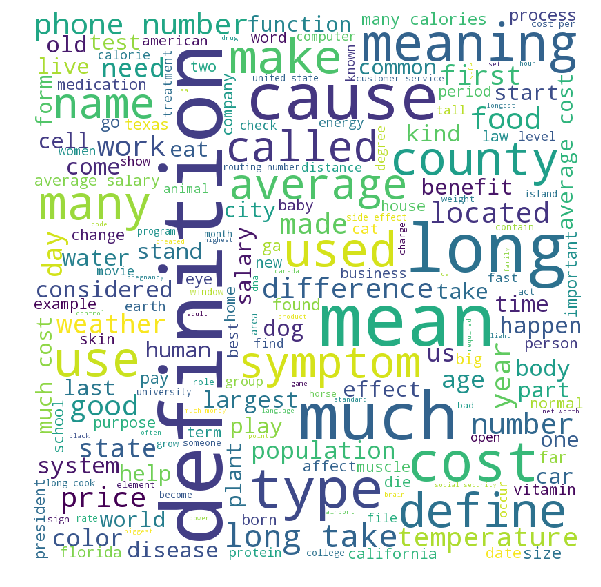

****************************************************************************************************
******************** Word Cloud for CV Data on Question********************


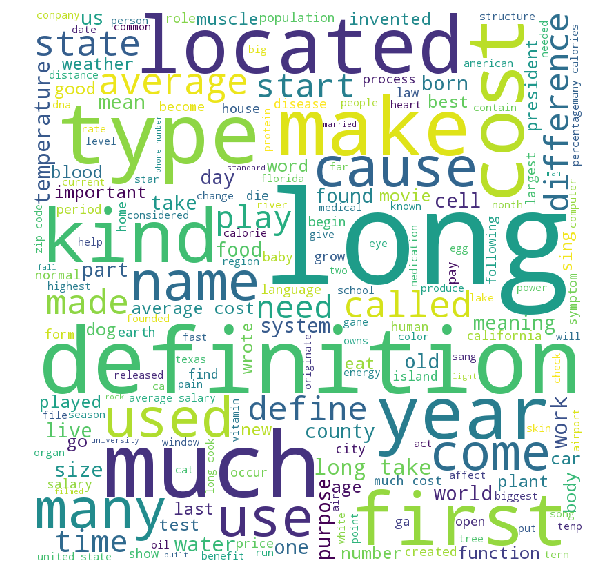

****************************************************************************************************
******************** Word Cloud for Test Data on Question********************


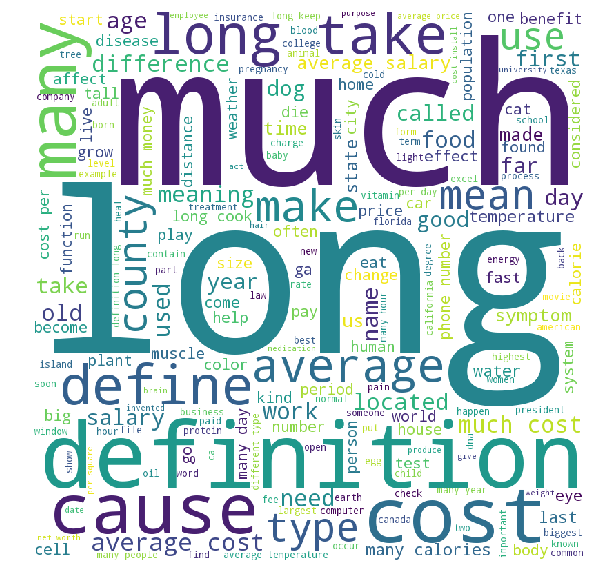

****************************************************************************************************


In [0]:
for count,data in enumerate([train_data,cv_data,test_data]):
    if count  == 0:
        data_name = 'Train Data'
    elif count == 1:
        data_name = 'CV Data'
    else:
        data_name = 'Test Data'

    Word_cloud(data,data_name,'Question')

### 10.2 Answer Word Cloud

-------------------- Word Cloud for Train Data on Answer--------------------


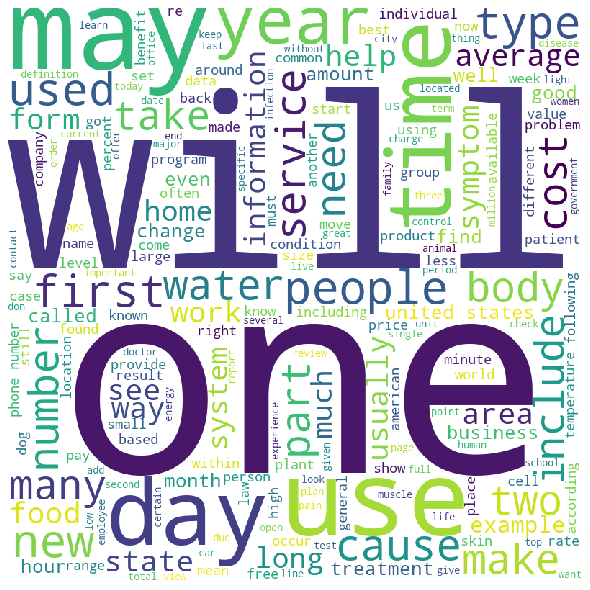

****************************************************************************************************
-------------------- Word Cloud for CV Data on Answer--------------------


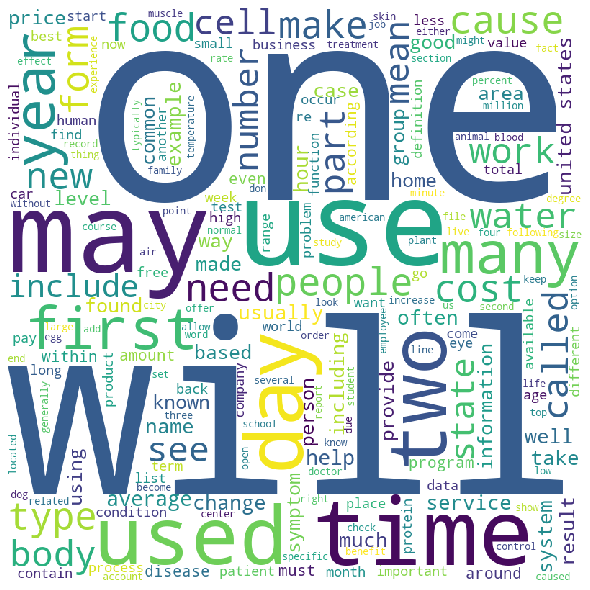

****************************************************************************************************
-------------------- Word Cloud for Test Data on Answer--------------------


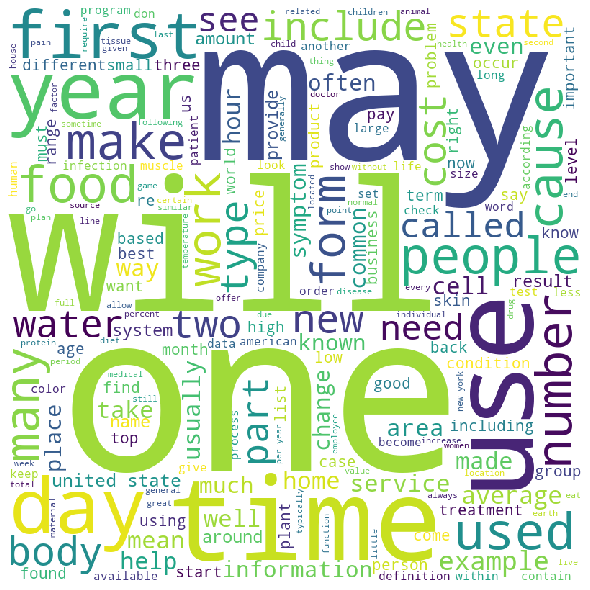

****************************************************************************************************


In [15]:
for count,data in enumerate([train_data,cv_data,test_data]):
    if count  == 0:
        data_name = 'Train Data'
    elif count == 1:
        data_name = 'CV Data'
    else:
        data_name = 'Test Data'

    Word_cloud(data,data_name,'Answer')

## 11. Padding

In [9]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the Amazon dataset
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import ast 
# fix random seed for reproducibility
numpy.random.seed(7)

In [3]:
#load data
train_data = pd.read_csv("Final_Test_Train_CV/train_data.csv").sort_values(by=['Question','Respose_number'])
cv_data= pd.read_csv('Final_Test_Train_CV/cv_data.csv').sort_values(by=['Question','Respose_number'])
test_data=pd.read_csv('Final_Test_Train_CV/test_data.csv').sort_values(by=['Question','Respose_number'])

In [4]:
#https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/
train_ecoded_ques = list(map(lambda X : ast.literal_eval(X), train_data.Question_vector))
cv_ecoded_ques = list(map(lambda X : ast.literal_eval(X), cv_data.Question_vector))
test_ecoded_ques = list(map(lambda X : ast.literal_eval(X), test_data.Question_vector))

train_ecoded_ans = list(map(lambda X : ast.literal_eval(X), train_data.Answer_vector))
cv_ecoded_ans = list(map(lambda X : ast.literal_eval(X), cv_data.Answer_vector))
test_ecoded_ans = list(map(lambda X : ast.literal_eval(X), test_data.Answer_vector))

In [6]:
#truncate and/or pad input sequences
Max_Question_length = 24
train_ques_vect = sequence.pad_sequences(list(train_ecoded_ques), maxlen=Max_Question_length)
cv_ques_vect = sequence.pad_sequences(cv_ecoded_ques, maxlen=Max_Question_length)
test_ques_vect = sequence.pad_sequences(test_ecoded_ques, maxlen=Max_Question_length)
print(train_ques_vect.shape)
print((train_ques_vect[1]))

(2009790, 24)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 8790 6221 2894 5905]


In [7]:
# truncate and/or pad input sequences
Max_Answer_length = 163
train_ans_vect = sequence.pad_sequences(train_ecoded_ans, maxlen=Max_Answer_length)
cv_ans_vect = sequence.pad_sequences(cv_ecoded_ans, maxlen=Max_Answer_length)
test_ans_vect = sequence.pad_sequences(test_ecoded_ans, maxlen=Max_Answer_length)
print(train_ans_vect.shape)
print((train_ans_vect[1]))

(2009790, 163)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 8993 8815 6274 5850 4710 3495 6410 8985 4024 5464 5464 6274
  835 7328 6362 2574 8233 8233 5850 9645 4699 4024 1091  743 3158  881
 8993 5937 2121 6784 5950  832 5950 7779 6314 9192  601 1223 6362 6410
 1223 1802   15 5453 9124 1184 6740 9447 2279]


In [10]:
np.save("For Neural Network/Ques_vect/train_ques_vect",train_ques_vect,allow_pickle = True)
np.save("For Neural Network/Ques_vect/cv_ques_vect",cv_ques_vect,allow_pickle = True)
np.save("For Neural Network/Ques_vect/test_ques_vect",test_ques_vect,allow_pickle = True)

np.save("For Neural Network/Ans_vect/train_ans_vect",train_ans_vect,allow_pickle = True)
np.save("For Neural Network/Ans_vect/cv_ans_vect",cv_ans_vect,allow_pickle = True)
np.save("For Neural Network/Ans_vect/test_ans_vect",test_ans_vect,allow_pickle = True)

np.save("For Neural Network/Target/train_target",train_data.Target,allow_pickle = True)
np.save("For Neural Network/Target/cv_target",cv_data.Target,allow_pickle = True)
np.save("For Neural Network/Target/test_target",test_data.Target,allow_pickle = True)